In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/tp2datostrain/train.csv
/kaggle/input/tp2datostrain/test.csv
/kaggle/input/pingsound/PING - Sound effect.mp3


In [2]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from IPython.display import Audio
sound_file = '/kaggle/input/pingsound/PING - Sound effect.mp3'

In [3]:
test = pd.read_csv("../input/tp2datostrain/test.csv")
display(test.shape)
train = pd.read_csv("../input/tp2datostrain/train.csv")
display(train.shape)

(60000, 22)

(240000, 23)

In [4]:
train.columns

Index(['id', 'titulo', 'descripcion', 'tipodepropiedad', 'direccion', 'ciudad',
       'provincia', 'antiguedad', 'habitaciones', 'garages', 'banos',
       'metroscubiertos', 'metrostotales', 'idzona', 'lat', 'lng', 'fecha',
       'gimnasio', 'usosmultiples', 'piscina', 'escuelascercanas',
       'centroscomercialescercanos', 'precio'],
      dtype='object')

In [68]:
cols_texto = ["titulo", "descripcion", "direccion"]
df = train
df.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,...,23533.0,NaN,NaN,2015-08-23 00:00:00,0.0,0.0,0.0,0.0,0.0,2273000.0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,...,24514.0,19.310205,-99.227655,2013-06-28 00:00:00,0.0,0.0,0.0,1.0,1.0,3600000.0
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,...,48551.0,NaN,NaN,2015-10-17 00:00:00,0.0,0.0,0.0,0.0,0.0,1200000.0
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,...,53666.0,19.301890,-99.688015,2012-03-09 00:00:00,0.0,0.0,0.0,1.0,1.0,650000.0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,...,47835.0,NaN,NaN,2016-06-07 00:00:00,0.0,0.0,0.0,0.0,0.0,1150000.0


## Analizo el texto
#### Uno el titulo y la descripcion en un solo texto.

In [69]:
df["titulo_descripcion"] = df["titulo"] + " " + df["descripcion"]
#Como tiene algunos nulos los relleno con cadenas vaicas
df["titulo_descripcion"].fillna("",inplace = True)

In [70]:
#REMUEVO LA PUNTUACION
import string
print(string.punctuation)
tabla = {}
for c in string.punctuation + "¿¡":
    tabla[ord(c)] = None
def sacar_puntuacion(s):
    return s.translate(tabla)
df["titulo_descripcion"] = df["titulo_descripcion"].apply(sacar_puntuacion)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [71]:
df["titulo_descripcion"].head()

0    depto tipo a402 depto interior de 8015m2 const...
1    condominio horizontal en venta pentre sonora y...
2    casa en venta urbi 3 recamaras tonala descripc...
3    casa sola en toluca zinacantepec con credito i...
4    paseos del sol bonito departamento en excelent...
Name: titulo_descripcion, dtype: object

In [72]:
#Agrego los primeros features
df["nro_palabras"] = df["titulo_descripcion"].apply(lambda x: len(x.split(" ")))
df["nro_caracteres"] = df["titulo_descripcion"].apply(lambda x: len(x))
df["long_prom_palabra"] = df["nro_caracteres"] / df["nro_palabras"]
df.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,titulo_descripcion,nro_palabras,nro_caracteres,long_prom_palabra
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2273000.0,depto tipo a402 depto interior de 8015m2 const...,29,178,6.137931
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,...,0.0,0.0,0.0,1.0,1.0,3600000.0,condominio horizontal en venta pentre sonora y...,98,691,7.051020
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1200000.0,casa en venta urbi 3 recamaras tonala descripc...,218,1339,6.142202
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,...,0.0,0.0,0.0,1.0,1.0,650000.0,casa sola en toluca zinacantepec con credito i...,64,418,6.531250
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1150000.0,paseos del sol bonito departamento en excelent...,19,113,5.947368


In [73]:
def llenarDiccionario(diccionario,descripcion):
    for palabra in descripcion.split():
        diccionario[palabra] = diccionario.get(palabra,0) + 1
        
def generarDiccionario(df2):
    dicc = {}
    for descripcion in df2['titulo_descripcion']:
        if isinstance(descripcion,str): llenarDiccionario(dicc,descripcion)
    return dicc
contador_palabras = generarDiccionario(df)
contador_palabras

{'depto': 7252,
 'tipo': 19480,
 'a402': 6,
 'interior': 8309,
 'de': 1108326,
 '8015m2': 1,
 'consta': 16491,
 'sala': 127397,
 'comedor': 106341,
 'cocina': 152626,
 'equipada': 30647,
 'área': 50379,
 'lavado': 57294,
 'baño': 183306,
 'completo': 65434,
 'recamara': 34662,
 'principal': 61115,
 'con': 599961,
 'closet': 43030,
 'y': 513741,
 '2da': 1037,
 'condominio': 21310,
 'horizontal': 3292,
 'en': 608698,
 'venta': 139364,
 'pentre': 39,
 'sonora': 288,
 'guerrero': 837,
 'atraacutes': 280,
 'del': 96650,
 'hospital': 2106,
 'aacutengeles': 65,
 'pedregal': 3136,
 'excelente': 69675,
 'estado': 12777,
 'conservacioacuten': 454,
 'construida': 5706,
 '3': 120362,
 'niveles': 30305,
 'estacionamiento': 61035,
 'para': 199860,
 '2': 174381,
 'autos': 54733,
 'recaacutemaras': 6438,
 'pisos': 23572,
 'madera': 18033,
 'natural': 6976,
 'la': 257789,
 'vestidor': 48751,
 'bantildeo': 22725,
 'bantildeos': 9942,
 'completos': 18308,
 'muros': 4527,
 'loseta': 7667,
 'espantildeola'

In [74]:

#Elimino las stopwords = palabras vacias que no suman nada
from nltk.corpus import stopwords
palabras_vacias = stopwords.words('spanish')

for palabra  in palabras_vacias:
    if palabra in contador_palabras:
        del contador_palabras[palabra]
ordenados = sorted(contador_palabras.items(),key = lambda x: -x[1])
top_50 = dict(ordenados[:50])

In [75]:
#Nuevos features
def contar_palabras_en_top(texto):
    palabras = texto.split()
    cont = 0
    for palabra in palabras:
        if palabra in top_50:
            cont += 1
    return cont
df["nro_palabras_mas_comunes"] = df["titulo_descripcion"].apply(contar_palabras_en_top)
df.head()

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,...,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,titulo_descripcion,nro_palabras,nro_caracteres,long_prom_palabra,nro_palabras_mas_comunes
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,...,0.0,0.0,0.0,0.0,2273000.0,depto tipo a402 depto interior de 8015m2 const...,29,178,6.137931,15
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,...,0.0,0.0,1.0,1.0,3600000.0,condominio horizontal en venta pentre sonora y...,98,691,7.051020,26
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,...,0.0,0.0,0.0,0.0,1200000.0,casa en venta urbi 3 recamaras tonala descripc...,218,1339,6.142202,24
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,...,0.0,0.0,1.0,1.0,650000.0,casa sola en toluca zinacantepec con credito i...,64,418,6.531250,6
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,...,0.0,0.0,0.0,0.0,1150000.0,paseos del sol bonito departamento en excelent...,19,113,5.947368,1


In [90]:
features = ["nro_palabras", "nro_caracteres", "long_prom_palabra", "nro_palabras_mas_comunes"]
X = train[features].copy()
y = train["precio"]
X_train,X_test,y_train,y_test = train_test_split(X, y,test_size=0.2, random_state = 0)

In [91]:
from sklearn.ensemble import RandomForestRegressor
clf = RandomForestRegressor(n_estimators = 40, max_depth = 8)
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=40,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [97]:
print("MAE: ", mean_absolute_error(clf.predict(X_test), y_test))
Audio(sound_file, autoplay=True)

SyntaxError: invalid syntax (<ipython-input-97-c5fa7b31a356>, line 1)

0    0.072095
1    0.170501
2    0.167091
3    0.590313
Name: importancia, dtype: float64

[Text(0, 0.5, 'Feature'), Text(0.5, 0, 'Importancia')]

<Figure size 1440x1440 with 0 Axes>

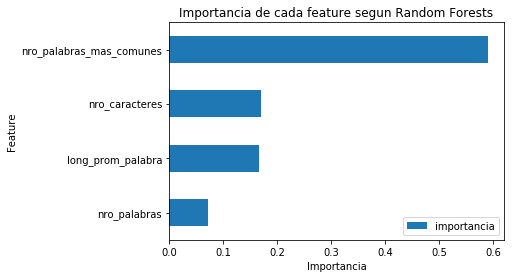

In [93]:
import matplotlib.pyplot as plt
impor = np.vstack((features, clf.feature_importances_)).T
imporDf = pd.DataFrame(impor)
imporDf.columns = ['feature', 'importancia']
imporDf["importancia"] = imporDf["importancia"].astype(float)
display(imporDf["importancia"].head())
imporDf = imporDf.set_index('feature').sort_values(by=['importancia'], ascending=False).iloc[::-1]
plt.figure(figsize=(20,20))
ax = imporDf.plot(kind='barh')
ax.set_title("Importancia de cada feature segun Random Forests")
ax.set(xlabel="Importancia", ylabel="Feature")